In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

ratings = pd.read_csv('/content/drive/MyDrive/ratings.csv', sep='\t', encoding='latin-1',
                      usecols=['user_id', 'movie_id', 'user_emb_id', 'movie_emb_id', 'rating'])

movies = pd.read_csv('/content/drive/MyDrive/movies.csv', sep='\t', encoding='latin-1',
                     usecols=['movie_id', 'title', 'genres'])

In [32]:
movies.head(5)

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [33]:
ratings.head(5)

,user_id,movie_id,rating,user_emb_id,movie_emb_id
0,1,1193,5,0,1192
1,1,661,3,0,660
2,1,914,3,0,913
3,1,3408,4,0,3407
4,1,2355,5,0,2354


### Content Based

**Objective**: Build a Content-Based Recommendation system that computes similarity between movies based on movie genres. It will suggest movies that are most similar to a particular movie based on its genre.

**Dataset**:
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Preprocess Data**:
   - Split the `genres` column into separate genre strings.
   - Fill any missing values in the `genres` column and convert it to string.

2. **Compute TF-IDF Matrix**:
   - Use `TfidfVectorizer` to transform the genres into a TF-IDF matrix.

3. **Calculate Cosine Similarity**:
   - Compute cosine similarity between the TF-IDF matrices of movies.

4. **Recommend Movies**:
   - Create a function that gets movie recommendations based on the cosine similarity score of movie genres.

In [34]:
movies['genres'] = movies['genres'].str.split('|')
movies['genres'] = movies['genres'].fillna("").astype('str')

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies['genres'])

In [36]:
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [37]:
def genre_recommendations(title, n=10):
    #TODO
    idx = movies[movies['title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sorted_sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sorted_sim_scores = sorted_sim_scores[1:n+1]
    movie_indices = [i[0] for i in sorted_sim_scores]
    return movies['title'].iloc[movie_indices]

In [38]:
# Example
genre_recommendations('GoldenEye (1995)')

345     Clear and Present Danger (1994)
543           Surviving the Game (1994)
724                    Rock, The (1996)
788                     Daylight (1996)
825               Chain Reaction (1996)
978                 Maximum Risk (1996)
1467                    Anaconda (1997)
1513                     Con Air (1997)
1693                   Firestorm (1998)
3686          Perfect Storm, The (2000)
Name: title, dtype: object


### Collaborative Filtering

**Objective**: Implement a collaborative filtering movie recommendation system to recommend movies to a user based on similar users' spreferences.

**Dataset**:

- **Ratings Data**: DataFrame with columns `user_id`, `movie_id`, and `rating`.
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Preprocess Data**:
   - Merge `ratings` and `movies` DataFrames on `movie_id`.
   - Split `genres` column into separate rows.

2. **Create User-Genre Matrix**:
   - Create a matrix where rows are users and columns are genres.
   - Each cell represents the ratio of movies watched by the user in that genre to the total movies watched by the user.

3. **Calculate User Similarity**:
   - Use cosine similarity to calculate the similarity between users.

4. **Find Top N Similar Users**:
   - Find the top N users with the most similar preferences to the given user.

5. **Recommend Movies**:
   - Recommend movies that similar users have watched but the target user has not.
   - Return titles and genres of the top 10 recommended movies.

In [39]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [40]:
data = pd.merge(ratings, movies, on='movie_id')

In [41]:
data.head(5)

,user_id,movie_id,rating,user_emb_id,movie_emb_id,title,genres
0,1,1193,5,0,1192,One Flew Over the Cuckoo's Nest (1975),['Drama']
1,2,1193,5,1,1192,One Flew Over the Cuckoo's Nest (1975),['Drama']
2,12,1193,4,11,1192,One Flew Over the Cuckoo's Nest (1975),['Drama']
3,15,1193,4,14,1192,One Flew Over the Cuckoo's Nest (1975),['Drama']
4,17,1193,5,16,1192,One Flew Over the Cuckoo's Nest (1975),['Drama']


In [42]:
data = data.assign(genres=data['genres'].str.split('|')).explode('genres')

In [43]:
data.head(5)

,user_id,movie_id,rating,user_emb_id,movie_emb_id,title,genres
0,1,1193,5,0,1192,One Flew Over the Cuckoo's Nest (1975),['Drama']
1,2,1193,5,1,1192,One Flew Over the Cuckoo's Nest (1975),['Drama']
2,12,1193,4,11,1192,One Flew Over the Cuckoo's Nest (1975),['Drama']
3,15,1193,4,14,1192,One Flew Over the Cuckoo's Nest (1975),['Drama']
4,17,1193,5,16,1192,One Flew Over the Cuckoo's Nest (1975),['Drama']


In [44]:
# Create User-Genre Matrix
user_genre_matrix = data.pivot_table(index='user_id', columns='genres', aggfunc='size', fill_value=0)
user_genre_matrix = user_genre_matrix.div(user_genre_matrix.sum(axis=1), axis=0)

In [45]:
user_genre_matrix

genres,"[""Children's"", 'Comedy', 'Drama']","[""Children's"", 'Comedy', 'Fantasy']","[""Children's"", 'Comedy', 'Musical']","[""Children's"", 'Comedy', 'Mystery']","[""Children's"", 'Comedy', 'Sci-Fi']","[""Children's"", 'Comedy', 'Western']","[""Children's"", 'Comedy']","[""Children's"", 'Drama', 'Fantasy', 'Sci-Fi']","[""Children's"", 'Drama', 'Fantasy']","[""Children's"", 'Drama']",...,"['Romance', 'War']","['Romance', 'Western']",['Romance'],"['Sci-Fi', 'Thriller', 'War']","['Sci-Fi', 'Thriller']","['Sci-Fi', 'War']",['Sci-Fi'],['Thriller'],['War'],['Western']
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.018868,0.0,0.000000,0.0,0.000000,0.018868,0.0,0.018868,...,0.0,0.0,0.018868,0.000000,0.000000,0.000000,0.000000,0.018868,0.0,0.000000
2,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.019608
4,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.047619,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
5,0.005051,0.000000,0.005051,0.0,0.000000,0.0,0.005051,0.000000,0.0,0.000000,...,0.0,0.0,0.010101,0.000000,0.005051,0.000000,0.000000,0.020202,0.0,0.005051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0.001126,0.001126,0.002252,0.0,0.002252,0.0,0.005631,0.001126,0.0,0.004505,...,0.0,0.0,0.003378,0.001126,0.009009,0.001126,0.010135,0.025901,0.0,0.005631
6037,0.004950,0.000000,0.000000,0.0,0.000000,0.0,0.004950,0.004950,0.0,0.000000,...,0.0,0.0,0.000000,0.004950,0.000000,0.004950,0.009901,0.074257,0.0,0.004950
6038,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.050000,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [46]:
user_similarity = cosine_similarity(user_genre_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_genre_matrix.index, columns=user_genre_matrix.index)

In [47]:
user_similarity_df

user_id,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.700616,0.263790,0.198349,0.746013,0.335790,0.034934,0.740531,0.768105,0.606995,...,0.599871,0.673598,0.192453,0.076218,0.596091,0.776295,0.709905,0.369019,0.428513,0.778642
2,0.700616,1.000000,0.234946,0.368718,0.885277,0.335986,0.370861,0.916273,0.890188,0.580996,...,0.659786,0.613919,0.491021,0.059787,0.688939,0.865308,0.818279,0.466579,0.318475,0.869229
3,0.263790,0.234946,1.000000,0.140733,0.447572,0.315127,0.063454,0.135451,0.350350,0.747341,...,0.618521,0.591616,0.191998,0.284297,0.637298,0.463486,0.376910,0.463023,0.551533,0.421064
4,0.198349,0.368718,0.140733,1.000000,0.239809,0.093633,0.521854,0.267352,0.245873,0.190546,...,0.312400,0.173916,0.592403,0.000000,0.231132,0.262354,0.237899,0.116052,0.073389,0.239081
5,0.746013,0.885277,0.447572,0.239809,1.000000,0.393560,0.151057,0.885451,0.937112,0.788511,...,0.774966,0.792514,0.291992,0.167262,0.850973,0.965926,0.890352,0.618813,0.478289,0.963891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0.776295,0.865308,0.463486,0.262354,0.965926,0.419800,0.125786,0.858938,0.921557,0.823929,...,0.783333,0.819872,0.282411,0.184822,0.885377,1.000000,0.923711,0.599418,0.528080,0.975951
6037,0.709905,0.818279,0.376910,0.237899,0.890352,0.336395,0.120445,0.803166,0.887061,0.692203,...,0.721386,0.701465,0.261771,0.180617,0.769411,0.923711,1.000000,0.527489,0.470513,0.905833
6038,0.369019,0.466579,0.463023,0.116052,0.618813,0.356260,0.000000,0.464387,0.551062,0.655391,...,0.643996,0.590362,0.109190,0.152894,0.629057,0.599418,0.527489,1.000000,0.504630,0.561851


In [66]:
def get_top_n_similar_users(user_id, n=5):
    #TODO
    if user_id not in user_similarity_df.index:
        return []
    similarity_scores = user_similarity_df[user_id]
    sorted_similar_users = similarity_scores.sort_values(ascending=False)
    sorted_similar_users = sorted_similar_users[sorted_similar_users.index != user_id]
    return sorted_similar_users.head(n).index

In [185]:
def recommend_movies(user_id, n_similar_users=5, n_recommendations=10):
    #TODO
    similar_users = get_top_n_similar_users(user_id, n_similar_users)
    if similar_users.empty:
        return pd.DataFrame(columns=['movie_id','title', 'genres'])
    similar_users_movies = data[data['user_id'].isin(similar_users)]
    watched_user_movies = data[data['user_id'] == user_id]['movie_id']
    recommendations = similar_users_movies[~similar_users_movies['movie_id'].isin(watched_user_movies)]
    top_recommendations = recommendations.groupby(['movie_id', 'title']).size().sort_values(ascending=False).head(n_recommendations).reset_index()
    top_recommendations = top_recommendations.merge(movies[['movie_id', 'genres']], on='movie_id')
    top_recommendations = top_recommendations.reset_index(drop=True)
    return top_recommendations[['title', 'genres']]


In [186]:
# Example
user_id = 1
recommended_movies = recommend_movies(user_id, n_similar_users=5, n_recommendations=10)

user_id
4767    0.886202
5702    0.872499
447     0.866739
4538    0.855035
1481    0.851153
Name: 1, dtype: float64


In [187]:
recommended_movies

,title,genres
0,"Silence of the Lambs, The (1991)","['Drama', 'Thriller']"
1,Amadeus (1984),['Drama']
2,Pinocchio (1940),"['Animation', ""Children's""]"
3,American Beauty (1999),"['Comedy', 'Drama']"
4,Alice in Wonderland (1951),"['Animation', ""Children's"", 'Musical']"
5,Sleeping Beauty (1959),"['Animation', ""Children's"", 'Musical']"
6,"Princess Mononoke, The (Mononoke Hime) (1997)","['Action', 'Adventure', 'Animation']"
7,Magnolia (1999),['Drama']
8,Say Anything... (1989),"['Comedy', 'Drama', 'Romance']"
9,Breakfast at Tiffany's (1961),"['Drama', 'Romance']"


### SVD (Singular Value Decomposition)



**Objective**: Implement an SVD-based recommendation system to recommend movies to users by decomposing the user-item interaction matrix into latent factors.

**Dataset**:
- **Ratings Data**: DataFrame with columns `user_id`, `movie_id`, and `rating`.
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Preprocess Data**:
   - Merge `ratings` and `movies` DataFrames on `movie_id`.
   - Create a user-item matrix where rows represent users, columns represent movies, and the values are the ratings.

2. **Decompose Matrix using SVD**:
   - Apply Singular Value Decomposition (SVD) to decompose the user-item matrix into three matrices: $U$, $\Sigma$, and $V^T$.

3. **Reconstruct Matrix**:
   - Reconstruct the user-item matrix using the top $k$ singular values to reduce dimensionality.

4. **Predict Ratings**:
   - Use the reconstructed matrix to predict ratings for all user-item pairs.

5. **Recommend Movies**:
   - Recommend the top 20 movies with the highest predicted ratings for a given user that the user hasn't rated yet.

In [188]:
n_users = ratings.user_id.unique().shape[0]
n_movies = ratings.movie_id.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_movies))

Number of users = 6040 | Number of movies = 3706


Fill na elements.

In [189]:
Ratings = ratings.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0)
Ratings.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# calculate rating matrix

In [206]:
U, sigma, Vt = np.linalg.svd(Ratings) # TODO
sigma = np.diag(sigma)

In [202]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)# TODO

In [205]:
preds = pd.DataFrame(all_user_predicted_ratings, columns= Ratings.columns)# TODO
preds.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,5.000000e+00,3.200908e-13,-5.675351e-15,-1.045024e-13,8.223565e-15,8.163942e-14,5.083388e-14,-1.060426e-14,-1.480192e-14,1.000175e-13,...,-9.972085e-16,-2.808084e-16,-1.453048e-15,3.241697e-16,-2.265983e-17,-2.657241e-14,-1.077477e-14,-3.637390e-15,1.342784e-16,-1.760012e-14
1,-1.824904e-14,-4.413222e-13,-1.241035e-13,1.087295e-13,-7.367303e-14,-1.605452e-13,-7.986383e-14,6.119687e-14,4.527905e-14,2.683098e-13,...,-1.447857e-15,1.387779e-17,-4.069011e-16,2.642262e-15,-7.377996e-16,1.313857e-15,1.704152e-14,3.687751e-15,1.056663e-15,7.611381e-15
2,-1.208318e-14,1.557112e-14,-8.338474e-14,2.580909e-14,2.216169e-14,2.637022e-14,-4.880755e-15,-7.547625e-14,1.288251e-14,-1.465711e-14,...,-1.033028e-15,4.108042e-16,-9.696020e-16,-9.422395e-16,6.826137e-16,3.740294e-15,1.767602e-15,7.446301e-16,-1.430496e-15,-2.949572e-16
3,-4.340309e-15,3.872019e-14,-1.756299e-15,1.037246e-13,1.374220e-13,-4.042245e-15,7.381818e-15,-1.317653e-14,5.430823e-15,5.913849e-15,...,-2.565358e-15,6.612549e-16,-1.231057e-15,-1.070812e-15,2.593872e-15,-5.137578e-15,-9.711284e-16,7.052735e-16,1.063060e-16,-6.853974e-15
4,-3.661544e-15,7.271440e-14,-5.278855e-15,3.964656e-15,-4.241811e-14,2.000000e+00,-3.418355e-14,-2.732878e-14,-2.291507e-14,-9.182325e-15,...,4.900499e-15,-1.504005e-15,-1.681652e-15,-1.537507e-15,3.342378e-15,4.950928e-15,5.704096e-15,-2.951740e-16,2.271078e-15,1.449687e-15


In [207]:
def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):

    user_row_number = userID - 1 # User ID starts at 1, not 0
    sorted_user_predictions = predictions.iloc[user_row_number].sort_values(ascending=False)# TODO

    user_data = original_ratings[original_ratings.user_id == (userID)]# TODO

    # merge movies data with user_data
    user_full = (user_data.merge(movies, how='left', left_on='movie_id', right_on='movie_id').
                     sort_values(['rating'], ascending=False)
                 ) # TODO


    print(f'User {userID} has already rated {user_full.shape[0]} movies.')
    print(f'Recommending highest {num_recommendations} predicted ratings movies not already rated.')

    recommendations = (movies[~movies['movie_id'].isin(user_full['movie_id'])].merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movie_id',right_on = 'movie_id').rename(columns = {user_row_number: 'Predictions'}).sort_values('Predictions', ascending = False).iloc[:num_recommendations, :-1]
                      )# TODO

    return user_full, recommendations

In [208]:
already_rated, predictions = recommend_movies(preds, 4375, movies, ratings, 20)

User 4375 has already rated 325 movies.
Recommending highest 20 predicted ratings movies not already rated.


In [209]:
ratings.head(20)

,user_id,movie_id,rating,user_emb_id,movie_emb_id
0,1,1193,5,0,1192
1,1,661,3,0,660
2,1,914,3,0,913
3,1,3408,4,0,3407
4,1,2355,5,0,2354
5,1,1197,3,0,1196
6,1,1287,5,0,1286
7,1,2804,5,0,2803
8,1,594,4,0,593
9,1,919,4,0,918


In [210]:
# Top 20 movies that User 4375 has rated
already_rated.head(20)

,user_id,movie_id,rating,user_emb_id,movie_emb_id,title,genres
195,4375,3250,5,4374,3249,Alive (1993),['Drama']
285,4375,175,5,4374,174,Kids (1995),['Drama']
199,4375,3257,5,4374,3256,"Bodyguard, The (1992)","['Action', 'Drama', 'Romance', 'Thriller']"
65,4375,3809,5,4374,3808,What About Bob? (1991),['Comedy']
210,4375,2688,5,4374,2687,"General's Daughter, The (1999)","['Drama', 'Thriller']"
270,4375,150,5,4374,149,Apollo 13 (1995),['Drama']
271,4375,2710,5,4374,2709,"Blair Witch Project, The (1999)",['Horror']
125,4375,349,5,4374,348,Clear and Present Danger (1994),"['Action', 'Adventure', 'Thriller']"
60,4375,288,5,4374,287,Natural Born Killers (1994),"['Action', 'Thriller']"
141,4375,47,5,4374,46,Seven (Se7en) (1995),"['Crime', 'Thriller']"


#### Evaluation

In [214]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)# TODO

train_ratings = train_data.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)# TODO
R_train = train_ratings.values
user_ratings_mean_train = np.mean(R_train, axis=1)# TODO
Ratings_demeaned_train = R_train - user_ratings_mean_train.reshape(-1, 1)

U_train, sigma_train, Vt_train = np.linalg.svd(Ratings_demeaned_train,full_matrices=False)# TODO
sigma_train = np.diag(sigma_train)

U_k = U_train[:, :20]
sigma_k = sigma_train[:20, :20]
Vt_k = Vt_train[:20, :]

all_user_predicted_ratings_train = np.dot(np.dot(U_k, sigma_k), Vt_k) + user_ratings_mean_train.reshape(-1, 1)# TODO
preds_train = pd.DataFrame(all_user_predicted_ratings_train, columns=train_ratings.columns)# TODO
user_id_to_index = {user_id: index for index, user_id in enumerate(train_ratings.index)}
movie_id_to_index = {movie_id: index for index, movie_id in enumerate(train_ratings.columns)}

def predict_rating(user_id, movie_id):
    # TODO
    if user_id in user_id_to_index and movie_id in movie_id_to_index:
        user_row_number = user_id_to_index[user_id]
        movie_col_number = movie_id_to_index[movie_id]
        pred = preds_train.iloc[user_row_number, movie_col_number] + user_ratings_mean_train[user_row_number]
        return pred
    else:
        return np.nan

test_data['predicted_rating'] = test_data.apply(lambda x: predict_rating(x['user_id'], x['movie_id']), axis=1)

test_data.dropna(inplace=True)

rmse = sqrt(mean_squared_error(test_data['rating'], test_data['predicted_rating']))
print(f'Root Mean Squared Error: {rmse}')


Root Mean Squared Error: 2.4924633045033477


### Nueral Network Model (Recommender Model)



**Objective**: Implement a Recommender model to recommend movies to a user based on similar users' preferences.

**Dataset**:
- **Ratings Data**: DataFrame with columns `user_id`, `movie_id`, and `rating`.
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Define Dataset and DataLoader**:
   - Create a custom PyTorch `Dataset` for ratings.
   - Create a DataLoader for batching and shuffling data.

2. **Define the Neural Network**:
   - Create a neural network with embedding layers for users and movies.

3. **Train the Model**:
   - Train the model using Mean Squared Error loss and Adam optimizer.
   - Save model checkpoints.

4. **Evaluate the Model**:
   - Calculate RMSE on the entire dataset.

5. **Predict Ratings for Unrated Movies**:
   - Predict and recommend top 10 unrated movies for a given user.

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [8]:
# Define the dataset
class RatingsDataset(Dataset):
    def __init__(self, ratings, user_id_map=None, movie_id_map=None):
        #TODO
        self.ratings = ratings.values
        if user_id_map is None:
            self.user_id_map = {id: idx for idx, id in enumerate(ratings['user_id'].unique())}
        else:
            self.user_id_map = user_id_map

        if movie_id_map is None:
            self.movie_id_map = {id: idx for idx, id in enumerate(ratings['movie_id'].unique())}
        else:
            self.movie_id_map = movie_id_map

    def __len__(self):
        #TODO
        return len(self.ratings)

    def __getitem__(self, idx):
        #TODO
        user_id = self.user_id_map[self.ratings[idx][0]]
        movie_id = self.movie_id_map[self.ratings[idx][1]]
        rating = self.ratings[idx][2]
        return torch.tensor(user_id, dtype=torch.long), torch.tensor(movie_id, dtype=torch.long), torch.tensor(rating, dtype=torch.float)

# Define the neural network
class RecommenderNet(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size=50):
        super(RecommenderNet, self).__init__()
        #TODO
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)
        self.fc1 = nn.Linear(embedding_size, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, user, movie):
        #TODO
        user_embedded = self.user_embedding(user)
        movie_embedded = self.movie_embedding(movie)
        x = user_embedded * movie_embedded
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze()
# Create the dataset and dataloader
user_id_map = {id: idx for idx, id in enumerate(ratings['user_id'].unique())}
movie_id_map = {id: idx for idx, id in enumerate(ratings['movie_id'].unique())}
num_users = len(user_id_map)
num_movies = len(movie_id_map)
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

# Create the datasets and dataloaders
train_dataset = RatingsDataset(train_data, user_id_map, movie_id_map)
test_dataset = RatingsDataset(test_data, user_id_map, movie_id_map)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# Initialize the model, loss function and optimizer
model = RecommenderNet(num_users, num_movies)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for user, movie, rating in train_loader:
        optimizer.zero_grad()
        output = model(user, movie)
        loss = criterion(output, rating)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}')
# Evaluation
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for user, movie, rating in test_loader:
        output = model(user, movie)
        predictions.extend(output.tolist())
        actuals.extend(rating.tolist())

rmse = sqrt(mean_squared_error(actuals, predictions))
print(f'Root Mean Squared Error: {rmse}')

Epoch 1/10, Loss: 1.2649681430015336
Epoch 2/10, Loss: 0.9322557717568872
Epoch 3/10, Loss: 0.8536681575717177
Epoch 4/10, Loss: 0.8066574439667401
Epoch 5/10, Loss: 0.7703268815400762
Epoch 6/10, Loss: 0.7389233448567757
Epoch 7/10, Loss: 0.7099215824856888
Epoch 8/10, Loss: 0.6831248428219368
Epoch 9/10, Loss: 0.6574028123595911
Epoch 10/10, Loss: 0.6335051813361969
Root Mean Squared Error: 0.9929844392145206


In [9]:
# Example

sample_user_id = 1
sample_user_data = ratings[ratings['user_id'] == sample_user_id]
sample_dataset = RatingsDataset(sample_user_data)
sample_dataloader = DataLoader(sample_dataset, batch_size=1, shuffle=False)

print(f'Sample predictions for user ID {sample_user_id}:')
with torch.no_grad():
    model.eval()
    for user, movie, rating in sample_dataloader:
        output = model(user, movie).squeeze()
        print(f'Movie ID: {movie.item()}, Predicted Rating: {output.item()}, Actual Rating: {rating.item()}')

Sample predictions for user ID 1:
Movie ID: 0, Predicted Rating: 4.023654460906982, Actual Rating: 5.0
Movie ID: 1, Predicted Rating: 4.633397579193115, Actual Rating: 3.0
Movie ID: 2, Predicted Rating: 4.104287147521973, Actual Rating: 3.0
Movie ID: 3, Predicted Rating: 4.086340427398682, Actual Rating: 4.0
Movie ID: 4, Predicted Rating: 3.408963203430176, Actual Rating: 5.0
Movie ID: 5, Predicted Rating: 4.711205959320068, Actual Rating: 3.0
Movie ID: 6, Predicted Rating: 4.353574275970459, Actual Rating: 5.0
Movie ID: 7, Predicted Rating: 4.361507892608643, Actual Rating: 5.0
Movie ID: 8, Predicted Rating: 3.9873621463775635, Actual Rating: 4.0
Movie ID: 9, Predicted Rating: 4.002224445343018, Actual Rating: 4.0
Movie ID: 10, Predicted Rating: 4.668864727020264, Actual Rating: 5.0
Movie ID: 11, Predicted Rating: 4.131300926208496, Actual Rating: 4.0
Movie ID: 12, Predicted Rating: 4.858864784240723, Actual Rating: 4.0
Movie ID: 13, Predicted Rating: 3.681494951248169, Actual Rating:

In [19]:
def predict_unrated_movies(user_id, model, ratings, movies, user_id_map, movie_id_map,top_n=10):
    #TODO
    rated_movie_ids = ratings[ratings['user_id'] == user_id]['movie_id'].tolist()
    unrated_movies = movies[~movies['movie_id'].isin(rated_movie_ids)]

    user_idx = user_id_map[user_id]

    unrated_movie_idxs = []
    for movie_id in unrated_movies['movie_id'].values:
        if movie_id in movie_id_map:
            unrated_movie_idxs.append(movie_id_map[movie_id])

    if not unrated_movie_idxs:
        print("No valid unrated movies found for prediction.")
        return pd.DataFrame()

    user_ids = torch.tensor([user_idx] * len(unrated_movie_idxs), dtype=torch.long)
    movie_ids = torch.tensor(unrated_movie_idxs, dtype=torch.long)

    model.eval()
    with torch.no_grad():
        predictions = model(user_ids, movie_ids)

    if len(predictions) != len(unrated_movies):
        if len(predictions) > len(unrated_movies):
            predictions = predictions[:len(unrated_movies)]
        else:
            missing_predictions = len(unrated_movies) - len(predictions)
            predictions = torch.cat([predictions, torch.zeros(missing_predictions)], dim=0)

    unrated_movies = unrated_movies.assign(predicted_rating=predictions.numpy())
    top_recommendations = unrated_movies.sort_values(by='predicted_rating', ascending=False).head(top_n)

    return top_recommendations
# Example
user_id = 1
predictions = predict_unrated_movies(user_id, model, ratings, movies, user_id_map, movie_id_map)
print(predictions)

      movie_id                                              title  \
3314      3383                                   Big Fella (1937)   
3110      3179                              Angela's Ashes (1999)   
1155      1171                                 Bob Roberts (1992)   
1130      1146                              Curtis's Charm (1995)   
1881      1950                    In the Heat of the Night (1967)   
3122      3191                                 Quarry, The (1998)   
3136      3205      Black Sunday (La Maschera Del Demonio) (1960)   
1340      1361  Paradise Lost: The Child Murders at Robin Hood...   
3604      3673                            Benji the Hunted (1987)   
2155      2224                                    Downhill (1927)   

                    genres  predicted_rating  
3314         Drama|Musical          5.798100  
3110                 Drama          5.787958  
1155                Comedy          5.785865  
1130          Comedy|Drama          5.785091  
1881 

### GMM (Gaussian Mixture Model)

**Objective**: Use a Gaussian Mixture Model to analyze and cluster the click data based on the number of clicks from different locations, aiming to identify distinct patterns of user behavior across 10 countries.

**Dataset**:
- **Click Data**: DataFrame with columns `link_id`, `location`, and `number_of_clicks`.

**Steps**:

1. **Preprocess Data**:
   - Ensure the dataset contains 10 distinct countries.
   - Create a matrix where rows represent different links and columns represent the number of clicks from each country.
   - Normalize the number of clicks to account for different scales.

2. **Fit GMM**:
   - Apply a Gaussian Mixture Model (GMM) to the click data matrix to identify clusters of links with similar click patterns across different countries.

3. **Evaluate Model**:
   - Analyze the resulting model by calculating the log lokelihood, BIC and AIC metrics.


In [27]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

file_path = '/content/drive/MyDrive/gmm-dataset.csv'# TODO
df = pd.read_csv(file_path)
df.head()

,URL,United States,China,India,Japan,Brazil,Russia,Indonesia,Germany,United Kingdom,France
0,url_1,657,194,310,790,768,436,189,973,448,335
1,url_2,389,149,354,729,629,937,345,967,764,104
2,url_3,979,475,509,769,270,705,113,931,977,213
3,url_4,524,699,692,694,473,160,484,37,956,899
4,url_5,767,661,319,572,399,401,277,596,631,203


In [23]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

Log-Likelihood: -305.3167418909935
BIC: 3645.4406363481394
AIC: 1928.633483781987
     URL  United States  China  India  Japan  Brazil  Russia  Indonesia  \
0  url_1            657    194    310    790     768     436        189   
1  url_2            389    149    354    729     629     937        345   
2  url_3            979    475    509    769     270     705        113   
3  url_4            524    699    692    694     473     160        484   
4  url_5            767    661    319    572     399     401        277   

   Germany  United Kingdom  France  Cluster  
0      973             448     335        6  
1      967             764     104        8  
2      931             977     213        8  
3       37             956     899        2  
4      596             631     203        8  


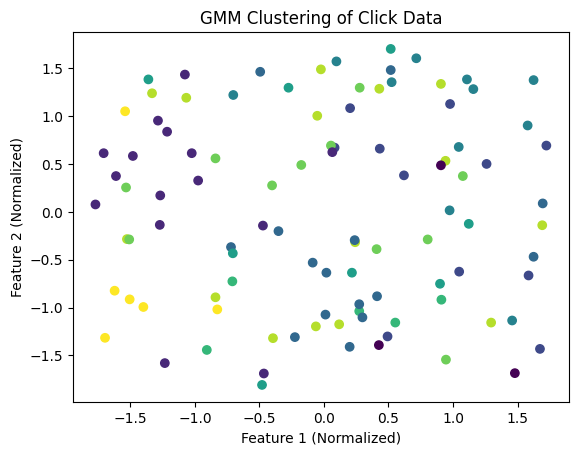

In [28]:
assert df.shape[1] == 11,"Dataset should contain 10 countries and 1 URL column."
urls = df['URL']
clicks_data = df.drop(columns=['URL'])
scaler = StandardScaler()
clicks_data_normalized = scaler.fit_transform(clicks_data)

gmm = GaussianMixture(n_components=10, random_state=42)# TODO
gmm.fit(clicks_data_normalized)

log_likelihood = gmm.score(clicks_data_normalized) * clicks_data_normalized.shape[0] # TODO
bic = gmm.bic(clicks_data_normalized)# TODO
aic = gmm.aic(clicks_data_normalized)# TODO

print(f"Log-Likelihood: {log_likelihood}")
print(f"BIC: {bic}")
print(f"AIC: {aic}")

labels = gmm.predict(clicks_data_normalized)

df['Cluster'] = labels
print(df.head())

plt.scatter(clicks_data_normalized[:, 0], clicks_data_normalized[:, 1], c=labels, cmap='viridis')
plt.title('GMM Clustering of Click Data')
plt.xlabel('Feature 1 (Normalized)')
plt.ylabel('Feature 2 (Normalized)')
plt.show()